In [1]:
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker

dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

#print('Atlas ROIs are located in nifti image (4D) at: %s' %    atlas_filename)  # 4D data

In [2]:

masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', verbose=5)


In [3]:
from nilearn.connectome import ConnectivityMeasure
import numpy as np
from nilearn import plotting
time_sta = 0
time_end = 45
size_step = 5

def compute_fc_series(data,time_sta,time_end,size_step):
    time_series = masker.fit_transform(data)
    series_matrix=[]

    while time_end <= time_series.shape[0]:
        time_series_this_window = time_series[time_sta:time_end]
        correlation_measure = ConnectivityMeasure(kind='correlation')
        correlation_matrix = correlation_measure.fit_transform([time_series_this_window])[0]
        time_sta += size_step
        time_end += size_step
        series_matrix.append(correlation_matrix)
    series_matrix = np.asarray(series_matrix)
    return series_matrix




In [17]:
#import test_fmri
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib # common way of importing nibabel

import numpy as np
import heartpy as hp
import math
import pandas as pd
from scipy import stats as st
import bioread
from scipy import ndimage
from os import path

Filepath = '/Users/dragon/Downloads/BREATHE'
fmripath = os.path.join(Filepath, 'fmri')
ecgpath = os.path.join(Filepath, 'ecg')

fs = 2000  # sampling rate of Biosignalplux
lowFreq = .1
highFreq = 100

def getFilterData(rawData):
    data = np.asarray(rawData)
    data = np.interp(data, (data.min(), data.max()), (0, +1024))
    #data = ((((data / np.power(2, 16)) - 0.5) * 3) / 1019) * 2000  # ecg manual pdf page 5
    #data = hp.filter_signal(data, [lowFreq, highFreq], fs, order=4, filtertype='bandpass', return_top=False)

    return data


def getHF(rawData):
    so=1-size_step/(time_end-time_sta)
    working_data, measures = hp.process_segmentwise(rawData, fs, segment_width=45, calc_freq=True, segment_overlap =so )
    lnHF_HRV = np.log(measures['hf'])
    rmssd=np.log(measures['rmssd'])
    return lnHF_HRV, rmssd



#print(ecgpath)
def listdirs(path):
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]


def extract_average_series(ts,sliding_window_size):
    #ts is a numpy array
    seriesofts= np.array_split(ts, int(ts.shape[-1]/sliding_window_size),axis=-1)
    seriesofts= np.asarray(seriesofts[:-1])
    last_element=np.asarray(seriesofts[-1])
    last_mean=np.mean(last_element,-1)
    mean_series = np.mean(seriesofts,-1)


    return np.concatenate((mean_series, np.expand_dims(last_mean, axis=0)), axis=0)

def builddatset(path):
    d_list = listdirs(path)
    all_subject_fmri_features=[]
    all_subject_ecg_features=[]
    names=[]
    for d in d_list:
        tem_path = os.path.join(path, d)
        if os.path.exists(os.path.join(tem_path,'final.feat','filtered_func_data.nii.gz')):
            mri_file = os.path.join(tem_path,'final.feat','filtered_func_data.nii.gz')
            fmri_feature=compute_fc_series(mri_file,time_sta,time_end,size_step)
            print(d+' fmri data extracted successfully')
            print('check the size')
            print(fmri_feature.shape)
            ecg_path_tem=os.path.join(tem_path, 'ecg')
            if os.path.exists(ecg_path_tem):
                for file in os.listdir(ecg_path_tem):
                    if file.endswith(".acq"):
                        print(os.path.join(ecg_path_tem, file))
                        data0 = bioread.read_file(os.path.join(ecg_path_tem, file))
                        rawdata = data0.channels[0].data
                        hf, rmssd = getHF(rawdata)
                        print(d + ' ecg feature extracted successfully')
                        names.append(os.path.join(ecg_path_tem, file))
                        print('check the data')
                        ecg_feature=rmssd[:fmri_feature.shape[0]]
               



            all_subject_fmri_features.append(fmri_feature)
            for i in range(ecg_feature.size):
                if np.isnan(ecg_feature[i]):
                    ecg_feature[i]=(ecg_feature[i-2]+ecg_feature[i-1])/2
            #print()
            print(ecg_feature)
            print(ecg_feature.shape)
            all_subject_ecg_features.append(ecg_feature)


        else:
            print('no_pre_fmri'+d)
            
    all_subject_fmri_features=np.asarray(all_subject_fmri_features)
    all_subject_ecg_features = np.asarray(all_subject_ecg_features)
    print(names)
    return all_subject_fmri_features, all_subject_ecg_features




In [ ]:
if __name__ == "__main__":
    #nonav_fmri_features=builddatset_nonav(fmripath)
    #print(nonav_fmri_features)
    #np.save('nonav_fmri_features', nonav_fmri_features)
    all_subject_fmri_features, all_subject_ecg_features =builddatset(fmripath)
    print(all_subject_fmri_features.shape)
    print(all_subject_ecg_features.shape)
    np.save('all_subject_fmri_features_region', all_subject_fmri_features)
    np.save('all_subject_ecg_features_region', all_subject_ecg_features)



[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[Memory]3522.5s, 58.7min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
s116 fmri data extracted successfully
check the size
(52, 48, 48)
/Users/dragon/Downloads/BREATHE/fmri/s116/ecg/BREATHE_s116_T1 (rest).acq


/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:253: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/heartpy/analysis.py:522: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.VLF is usually computed over a minimum of 5 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an a

s116 ecg feature extracted successfully
check the data
[5.10737914 5.05488869 5.00678943 5.00678943 4.63082558 5.29760279
 5.41359289 5.62323166 5.48146674 2.8772774  5.19851992 5.53761629
 5.2550591  5.16357548 5.20577042 5.19691618 5.34570567 5.45906578
 5.47342617 5.40536026 2.14608515 4.37092779 4.97431769 5.2182026
 5.22578332 5.18754914 5.51667382 5.23582646 5.31790696 5.35317859
 5.32305092 5.27011691 5.31291731 5.29963958 5.30751579 5.37208318
 5.3367458  5.32930697 5.30801746 5.32071475 5.30124651 5.3261009
 5.28368176 5.31067154 5.25645273 5.18939114 5.23072526 5.11213537
 5.40708671 5.37204856 5.33114089 5.13321609]
(52,)
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[Memory]3532.5s, 58.9min: Loading _filter_and_extract...
__________________________________filter

/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/heartpy/analysis.py:522: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.VLF is usually computed over a minimum of 5 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more info see: 
Shaffer, F., Ginsberg, J.P. (2017), An Overview of Heart Rate Variability Metrics and Norms.

Task Force of Pacing and Electrophysiology (1996), Heart Rate Variability, in: European Heart Journal, vol.17, issue 3, pp354-381

This warning will not repeat
  warnings.warn(msg, UserWarning)
/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sc

s118 ecg feature extracted successfully
check the data
[5.59638257 5.40203588 5.40203588 5.36031146 5.35258647 5.42056716
 5.30959139 5.65148487 5.49991431 5.61455856 5.61455856 5.59457113
 5.63628441 5.59910118 5.61362128 5.55165859 5.55929781 5.60480572
 5.59791416 5.52305587 5.45171924 5.38505204 5.42497719 5.48743326
 5.48500565 5.47437082 5.63010034 5.71069436 5.67641463 5.67641463
 5.67641463 5.4773272  5.47028587 5.45121237 5.63229918 5.53246021
 5.58771135 5.6203943  5.56459426 5.58889825 5.42309255 5.30453969
 5.20526853 5.76167184 5.76778256 5.76294709 5.57957294 5.83448981
 5.82687377 5.60896239 5.60896239 5.54158029]
(52,)
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[Memory]3547.7s, 59.1min: Loading _filter_and_extract...
__________________________________filt

/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/heartpy/analysis.py:522: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.VLF is usually computed over a minimum of 5 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more info see: 
Shaffer, F., Ginsberg, J.P. (2017), An Overview of Heart Rate Variability Metrics and Norms.

Task Force of Pacing and Electrophysiology (1996), Heart Rate Variability, in: European Heart Journal, vol.17, issue 3, pp354-381

This warning will not repeat
  warnings.warn(msg, UserWarning)
/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sc

s127 ecg feature extracted successfully
check the data
[5.59096968 5.65610734 5.7396626  5.68766542 5.68720993 5.69572282
 5.69643486 5.66138469 5.75437281 5.79924862 5.79243671 5.79991498
 5.72393146 5.69666732 5.72309827 5.67029801 5.70433313 5.69886181
 5.69886181 5.62780729 5.60133537 5.62588703 5.53798187 5.63236675
 5.66974407 5.60981304 5.63456474 5.60232973 5.63381663 5.67279708
 5.65248536 5.65338678 5.58683356 5.61610924 5.53613699 5.68049343
 5.71603225 5.69330002 5.62828167 5.6419146  5.71737747 5.55059768
 5.65289793 5.71010122 5.70160971 5.61061953 5.57204886 5.64175342
 5.63686993 5.6427216  5.67248416 5.65404471]
(52,)
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[Memory]3563.2s, 59.4min: Loading _filter_and_extract...
__________________________________filt

/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/ma/core.py:5244: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/heartpy/analysis.py:522: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually co

s180 ecg feature extracted successfully
check the data
[3.73439883 4.95945608 5.22155921 5.17211477 5.19996635 5.13244575
 5.12647669 5.13001018 5.32353297 5.48202451 5.55339757 5.66361887
 5.66361887 5.66361887 5.62045408 5.66686693 5.77470656 5.34760945
 5.00239313 5.04486749 5.07923524 5.32731914 5.25184055 5.29764314
 5.30092815 5.49632357 5.40928921 5.46907366 5.51071904 5.34468671
 5.5597698  2.01490302 1.70474809 4.53259949 1.70474809 4.88763529
 4.88763529 4.88763529 0.76573819 1.09861229 1.38889177 1.09861229
 1.09861229 5.72512942 5.73494579 5.82750526 5.38052078 5.3888523
 5.39213354 5.32406292 5.27157308 2.19722458]
(52,)
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[Memory]3579.0s, 59.7min: Loading _filter_and_extract...
__________________________________filte

/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/heartpy/analysis.py:522: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.VLF is usually computed over a minimum of 5 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more info see: 
Shaffer, F., Ginsberg, J.P. (2017), An Overview of Heart Rate Variability Metrics and Norms.

Task Force of Pacing and Electrophysiology (1996), Heart Rate Variability, in: European Heart Journal, vol.17, issue 3, pp354-381

This warning will not repeat
  warnings.warn(msg, UserWarning)
/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sc

s142 ecg feature extracted successfully
check the data
[4.92905116 5.0116318  4.3464356  5.16416138 5.2726625  5.28822991
 5.31849128 5.33512108 5.37357979 5.13738595 5.57030792 4.64410433
 4.6248416  4.63028047 4.80783645 4.68752345 4.47288113 5.11135402
 5.17704211 3.46443583 5.23516992 4.74644684 5.23427543 5.47238603
 5.605032   5.26613691 5.30398478 4.02964376 5.39106868 5.53259718
 5.74465353 5.60940449 5.58724228 5.62691601 5.28651122 5.25555313
 5.30113181 5.09251694 5.21193647 5.22369095 5.25515119 4.9225248
 5.32837903 4.63719329 5.19040356 4.60286039 4.81815651 4.85446763
 5.12305097 5.24835824 5.41999395 4.3721222 ]
(52,)
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[Memory]3594.9s, 59.9min: Loading _filter_and_extract...
__________________________________filte

/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/heartpy/analysis.py:522: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.VLF is usually computed over a minimum of 5 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more info see: 
Shaffer, F., Ginsberg, J.P. (2017), An Overview of Heart Rate Variability Metrics and Norms.

Task Force of Pacing and Electrophysiology (1996), Heart Rate Variability, in: European Heart Journal, vol.17, issue 3, pp354-381

This warning will not repeat
  warnings.warn(msg, UserWarning)
/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sc

s128 ecg feature extracted successfully
check the data
[5.32094674 5.22897574 5.26630551 5.13104519 5.21187856 5.21760979
 5.32261425 5.37559389 5.33061724 5.31014496 5.17872622 5.20832243
 5.27783935 5.24447004 5.13522657 5.13854047 5.14539216 5.16074255
 5.20107946 5.25483105 5.30957636 5.10190748 5.08841744 5.42933649
 5.26734143 5.52136691 5.52162689 5.56962645 5.53381553 5.15077517
 4.93225424 4.61172701 5.11603581 4.92048682 4.92048682 5.24702407
 5.24702407 5.4292693  5.20084726 5.28231034 5.22938627 5.32165691
 4.45546152 5.05549301 5.05549301 4.98198129 4.46890207 4.46890207
 4.54836742 4.46890207 4.54402281 5.52904412]
(52,)
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[Memory]3616.8s, 60.3min: Loading _filter_and_extract...
__________________________________filt

/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/heartpy/analysis.py:522: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.VLF is usually computed over a minimum of 5 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more info see: 
Shaffer, F., Ginsberg, J.P. (2017), An Overview of Heart Rate Variability Metrics and Norms.

Task Force of Pacing and Electrophysiology (1996), Heart Rate Variability, in: European Heart Journal, vol.17, issue 3, pp354-381

This warning will not repeat
  warnings.warn(msg, UserWarning)
/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sc

s144 ecg feature extracted successfully
check the data
[4.56194925 4.61731773 4.44697441 4.64113558 4.64113558 5.05759242
 5.63612884 5.62747386 5.62359088 5.59760345 5.63602434 5.62092738
 5.7317142  5.72456635 5.72051551 5.72685008 5.76528022 5.75549089
 5.72221615 5.75389046 5.73833638 5.75398841 5.75004584 5.7679348
 5.74777401 5.70155968 5.6966116  5.74231462 5.72699096 5.67972265
 5.74773933 5.73764682 5.60479934 5.63821997 5.76746126 5.63837853
 5.72000257 5.75683296 5.71693295 5.72135258 5.73718437 5.73653209
 5.76397058 5.74068918 5.72758341 5.76901955 5.769236   5.78187444
 5.79316954 5.79411604 5.5714126  5.62608782]
(52,)
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[Memory]3634.4s, 60.6min: Loading _filter_and_extract...
__________________________________filte

/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/heartpy/analysis.py:522: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.VLF is usually computed over a minimum of 5 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more info see: 
Shaffer, F., Ginsberg, J.P. (2017), An Overview of Heart Rate Variability Metrics and Norms.

Task Force of Pacing and Electrophysiology (1996), Heart Rate Variability, in: European Heart Journal, vol.17, issue 3, pp354-381

This warning will not repeat
  warnings.warn(msg, UserWarning)
/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sc

s210 ecg feature extracted successfully
check the data
[5.36952563 5.44075768 4.80916261 4.48563692 5.5243479  5.23708522
 5.23708522 5.25820229 5.25820229 5.68646447 5.42836456 5.46230349
 4.90544759 5.411069   6.2257246  6.2257246  6.2257246  5.53736097
 5.41264404 5.75732324 5.75732324 5.5305041  5.21462614 5.28923517
 5.53881881 5.31834552 5.31888721 5.35619984 5.35619984 5.55613936
 5.63947549 5.66524209 5.59011156 5.58568553 5.57751498 5.51218029
 5.61448696 5.18355238 5.18355238 5.37527841 5.37527841 5.18608989
 5.12055992 4.57471098 4.57471098 5.42255445 5.97031991 5.14653231
 5.38907173 5.60413508 5.28604579 5.44509043]
(52,)
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[Memory]3650.7s, 60.8min: Loading _filter_and_extract...
__________________________________filt

/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/heartpy/analysis.py:522: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.VLF is usually computed over a minimum of 5 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more info see: 
Shaffer, F., Ginsberg, J.P. (2017), An Overview of Heart Rate Variability Metrics and Norms.

Task Force of Pacing and Electrophysiology (1996), Heart Rate Variability, in: European Heart Journal, vol.17, issue 3, pp354-381

This warning will not repeat
  warnings.warn(msg, UserWarning)
/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sc

s161 ecg feature extracted successfully
check the data
[5.160735   5.18998572 5.17467795 5.25490204 5.30498811 5.22047822
 5.20919945 5.36351531 5.29442862 5.33442369 5.39371277 5.40160736
 5.45822724 5.43211305 5.39363091 5.40751257 5.25548491 5.33416171
 5.35118518 5.53269762 5.37032219 5.533836   5.67306882 5.61096254
 5.71376203 5.67593846 5.36135729 5.43109362 5.56390207 5.26298084
 5.28606301 5.40146738 5.21626878 5.26404621 5.24522745 5.23938356
 5.3760839  5.26735736 4.85996204 5.12710994 5.1959312  5.36204351
 4.14785746 3.97363131 3.97363131 3.89352155 4.76096643 4.83876703
 4.82047164 5.29373834 5.25481753 5.2885102 ]
(52,)
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[Memory]3672.8s, 61.2min: Loading _filter_and_extract...
__________________________________filt

/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/heartpy/analysis.py:522: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.VLF is usually computed over a minimum of 5 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more info see: 
Shaffer, F., Ginsberg, J.P. (2017), An Overview of Heart Rate Variability Metrics and Norms.

Task Force of Pacing and Electrophysiology (1996), Heart Rate Variability, in: European Heart Journal, vol.17, issue 3, pp354-381

This warning will not repeat
  warnings.warn(msg, UserWarning)
/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sc

s194 ecg feature extracted successfully
check the data
[5.36852636 5.36852636 5.36852636 5.36852636 5.36615204 5.07371253
 5.67171712 5.36615204 5.51893458 4.49021197 5.57132849 5.03077023
 5.49921531 5.25767573 5.23859821 5.24813697 5.24336759 4.7095302
 5.04055355 4.7095302  4.7095302  5.1638654  5.6167711  5.6167711
 5.76675727 5.26475778 5.35709591 5.5358489  5.5358489  5.49197112
 4.93594942 5.57477563 5.51870875 5.63125733 5.60198525 5.58508593
 5.47731161 5.48755952 5.30317209 5.41635767 5.19235885 5.2960242
 5.26694813 5.50671562 5.39642886 5.39859408 5.71384387 5.39092397
 5.49586111 5.54314581 5.55793231 5.94017125]
(52,)
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[Memory]3688.4s, 61.5min: Loading _filter_and_extract...
__________________________________filter_

/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/heartpy/analysis.py:522: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.VLF is usually computed over a minimum of 5 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more info see: 
Shaffer, F., Ginsberg, J.P. (2017), An Overview of Heart Rate Variability Metrics and Norms.

Task Force of Pacing and Electrophysiology (1996), Heart Rate Variability, in: European Heart Journal, vol.17, issue 3, pp354-381

This warning will not repeat
  warnings.warn(msg, UserWarning)
/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sc

s184 ecg feature extracted successfully
check the data
[5.34443126 5.51593379 5.52691006 5.47255982 5.58218232 5.64394291
 5.55281627 5.55978408 5.46853525 5.44054251 5.41949716 5.42597751
 5.42871231 5.32798777 5.35508034 5.29094699 5.23171965 5.29231852
 5.377215   5.46386703 5.52023428 5.5554487  5.53463566 5.51890173
 5.54098307 5.55571653 5.6089901  5.56102814 5.56376725 5.47093351
 5.51443382 5.55335886 5.58699123 5.59830475 5.65473204 5.52111232
 5.70594113 5.51868258 5.54380338 5.4933398  5.53631563 5.53308681
 5.37900577 5.45264733 5.52860253 5.5260379  5.48284607 5.67024766
 5.60519942 5.69200936 5.64856467 5.62952877]
(52,)
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[Memory]3711.1s, 61.9min: Loading _filter_and_extract...
__________________________________filt

/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/heartpy/analysis.py:522: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.VLF is usually computed over a minimum of 5 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more info see: 
Shaffer, F., Ginsberg, J.P. (2017), An Overview of Heart Rate Variability Metrics and Norms.

Task Force of Pacing and Electrophysiology (1996), Heart Rate Variability, in: European Heart Journal, vol.17, issue 3, pp354-381

This warning will not repeat
  warnings.warn(msg, UserWarning)
/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sc

s124 ecg feature extracted successfully
check the data
[5.25745616 5.20699192 5.08950555 5.1228136  5.16607547 5.07049124
 5.14811835 5.2774088  5.27442357 2.76230245 2.80592686 2.71439862
 2.72565059 2.82858741 2.90513911 5.37662134 2.9160995  5.3453372
 5.31984891 5.31848541 5.26881322 5.31230198 5.28708452 5.24222631
 5.27577052 5.30578351 5.39125535 3.30016811 3.31955397 3.3145472
 3.42971801 3.48219936 3.4948956  3.49787354 3.5281844  3.48229519
 5.45262054 5.36812378 3.23346984 3.24223279 3.19693007 3.52827806
 3.5119756  3.48651446 3.19525874 3.25749238 3.25245197 3.26036809
 3.196742   3.16547637 3.20493217 3.18333326]
(52,)
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[Memory]3727.3s, 62.1min: Loading _filter_and_extract...
__________________________________filter

/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/heartpy/analysis.py:522: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.VLF is usually computed over a minimum of 5 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more info see: 
Shaffer, F., Ginsberg, J.P. (2017), An Overview of Heart Rate Variability Metrics and Norms.

Task Force of Pacing and Electrophysiology (1996), Heart Rate Variability, in: European Heart Journal, vol.17, issue 3, pp354-381

This warning will not repeat
  warnings.warn(msg, UserWarning)
/Users/dragon/opt/anaconda3/envs/py37/lib/python3.7/site-packages/nu

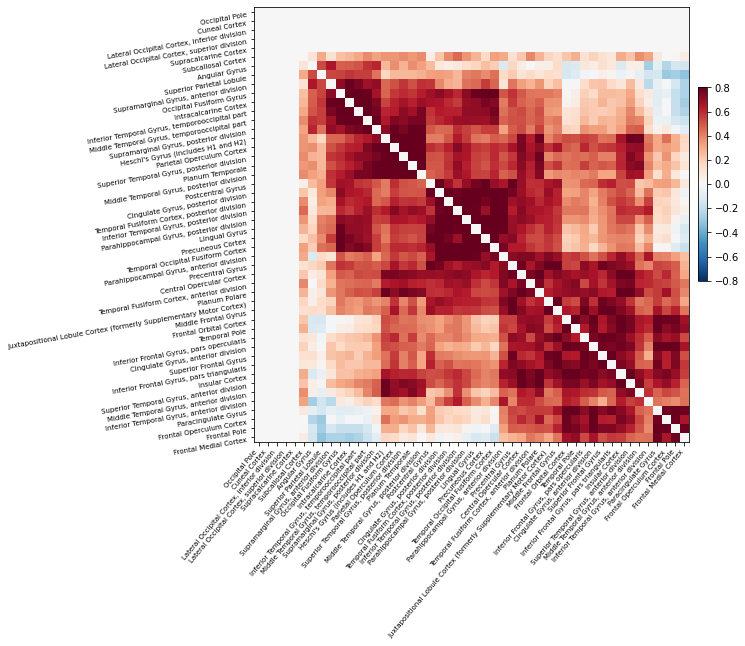

In [15]:
# Plot the correlation matrix
correlation_matrix=all_subject_fmri_features[0,48,:,:]
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels[1:],
                     vmax=0.8, vmin=-0.8,
                     reorder=True)

In [16]:
pss=np.asarray([0.9,1.5,1.9,1.6,1.5,0.8,2.5,1.4,1.1,2,0.3,0.5,0.9,0.7,2.5,1.7,0.6,1.1,1.9])
print(pss.shape)

(19,)
